In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
image_dimensions = (512, 512) # height, width
with_augmentation = False
batch_size = 16
model_version = "XCeption"
model_file = f'/content/drive/MyDrive/lion_no_lion/model_weights_Adis_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.keras'
history_file = f'/content/drive/MyDrive/lion_no_lion/model_history_Adis_{model_version}_{image_dimensions[0]}_{image_dimensions[1]}.pickle'
lion_directories = [
    '/content/drive/MyDrive/lion_no_lion/lion',
    '/content/drive/MyDrive/lion_no_lion/cougar',
]
no_lion_directories = [
    '/content/drive/MyDrive/lion_no_lion/no_lion',
    '/content/drive/MyDrive/lion_no_lion/nocougar',
]

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  distribution_strategy = tf.distribute.TPUStrategy(tpu)
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  print("WARNING: Not connected to a TPU runtime; WIll try GPU")
  if tf.config.list_physical_devices('GPU'):
    distribution_strategy = tf.distribute.MirroredStrategy()
    print(f'Running on {len(tf.config.list_physical_devices("GPU"))} GPUs')
  else:
    print('WARNING: Not connected to TPU or GPU runtime; Will use CPU context')
    distribution_strategy = tf.distribute.get_strategy()

Tensorflow version 2.15.0
Running on a TPU w/8 cores


In [7]:
import os

with distribution_strategy.scope():
    try:
        os.stat(model_file)
        print(f'Loading model from file {model_file}')
        model = tf.keras.models.load_model(model_file)
        print('Loaded model from file')
    except FileNotFoundError:
        if model_version == "XCeption":
            print('Creating new XCeption model')
            base_model = tf.keras.applications.Xception(
                weights='imagenet',
                include_top=False,
                input_shape=(*image_dimensions, 3),
            )

            print(f'Number of layers in the base model: {len(base_model.layers)}')
            print(f'Shape of the output layer:          {base_model.layers[-1].output_shape}')

            base_model.trainable = False

            input_layers = []
            if with_augmentation:
                input_layers = [
                    tf.keras.layers.RandomFlip(),
                    tf.keras.layers.RandomRotation(0.01),
                    tf.keras.layers.RandomZoom(0.05),
                    tf.keras.layers.RandomBrightness((-0.1, 0.1)),
                    tf.keras.layers.RandomContrast(0.1),
                    # tf.keras.layers.RandomCrop(200, 200),
                    # tf.keras.layers.Rescaling(1./255),
                ]

            model = tf.keras.Sequential([
                *input_layers,
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(1, activation='sigmoid'),
            ])
        else:
            raise Exception(f'unknonw model version {model_version}')

        model.build(input_shape=(None, *image_dimensions, 3))

Creating new XCeption model
83683744/83683744 [==============================] - 0s 0us/step
Number of layers in the base model: 132
Shape of the output layer:          (None, 16, 16, 2048)


In [8]:
with distribution_strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [9]:
import pickle

class StoreHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.history = {}
        self.number_epochs = 0
        try:
            with open(history_file, 'rb') as f:
                self.history = pickle.load(f)
                self.number_epochs = len(self.history['loss'])
                print(f'Loaded history of {self.number_epochs} previous epochs')
                print(f'Epoch {self.number_epochs}: '
                      f'loss: {self.history["loss"][-1]:.4f} - '
                      f'accuracy: {self.history["accuracy"][-1]:.4f} - '
                      f'val_loss: {self.history["val_loss"][-1]:.4f} - '
                      f'val_accuracy: {self.history["val_accuracy"][-1]:.4f}')
        except FileNotFoundError:
            print('Initialized new history')
            pass

    def on_train_begin(self, logs=None):
        if not 'loss' in self.history:
            self.history['loss'] = []
        self.number_epochs = len(self.history['loss'])
        print(f'Starting new training with {self.number_epochs} previous epochs')

    def on_epoch_end(self, epoch, logs=None):
        if not 'batch_size' in self.history:
            self.history['batch_size'] = []
        self.history['batch_size'].append(batch_size)
        for key in logs:
          if not key in self.history:
              self.history[key] = []
          self.history[key].append(logs[key])
        with open(history_file, 'wb') as f:
            pickle.dump(self.history, f)
            print(f'Epoch {epoch + self.number_epochs + 1} history pickled and saved to file')

full_history = StoreHistory()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

Initialized new history


In [10]:
import glob
import shutil

lion_images = []
for lion in lion_directories:
    lion_images += glob.glob(os.path.join(lion, '*JPG'))
no_lion_images = []
for no_lion in no_lion_directories:
    no_lion_images += glob.glob(os.path.join(no_lion, '*JPG'))

print(f'Found {len(lion_images)} images tagged as `lion`')
print(f'Found {len(no_lion_images)} images tagges as `no-lion`')
print(f'In total {len(lion_images) + len(no_lion_images)} images')

shutil.rmtree('data', ignore_errors=True)
os.makedirs('data/lion')
os.makedirs('data/no_lion')

for image in lion_images:
    shutil.copy(image, 'data/lion')
for image in no_lion_images:
    shutil.copy(image, 'data/no_lion')

print('Copied all images')

Found 684 images tagged as `lion`
Found 618 images tagges as `no-lion`
In total 1302 images
Copied all images


In [11]:
training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='both',
    seed=1042,
    shuffle=True,
    image_size=image_dimensions,
    color_mode='rgb',
)

Found 1281 files belonging to 2 classes.
Using 1025 files for training.
Using 256 files for validation.


In [12]:
from datetime import datetime

start_time = datetime.now()
print(start_time)
history = model.fit(
    training_dataset,
    epochs=300,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/lion_no_lion/logs'),
        checkpoint,
        full_history,
    ]
)
end_time = datetime.now()
print(end_time)
print(f'This run took {(end_time - start_time).total_seconds()} seconds')

2024-05-31 21:30:19.022409
Starting new training with 0 previous epochs
Epoch 1/300
 6/65 [=>............................] - ETA: 4s - loss: 2.6623 - accuracy: 0.5000

65/65 [==============================] - ETA: 0s - loss: 2.5889 - accuracy: 0.5054
Epoch 1: val_loss improved from inf to 2.22551, saving model to /content/drive/MyDrive/lion_no_lion/model_weights_Adis_XCeption_512_512.keras
Epoch 1 history pickled and saved to file
65/65 [==============================] - 30s 239ms/step - loss: 2.5889 - accuracy: 0.5054 - val_loss: 2.2255 - val_accuracy: 0.4961
Epoch 2/300
64/65 [============================>.] - ETA: 0s - loss: 1.9081 - accuracy: 0.5410
Epoch 2: val_loss improved from 2.22551 to 1.61592, saving model to /content/drive/MyDrive/lion_no_lion/model_weights_Adis_XCeption_512_512.keras
Epoch 2 history pickled and saved to file
65/65 [==============================] - 7s 98ms/step - loss: 1.9063 - accuracy: 0.5415 - val_loss: 1.6159 - val_accuracy: 0.5312
Epoch 3/300
65/65 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.5824
Epoch 3: val_loss improved from 1.61592 to 1.28597, saving model to /content/drive/MyDrive/li

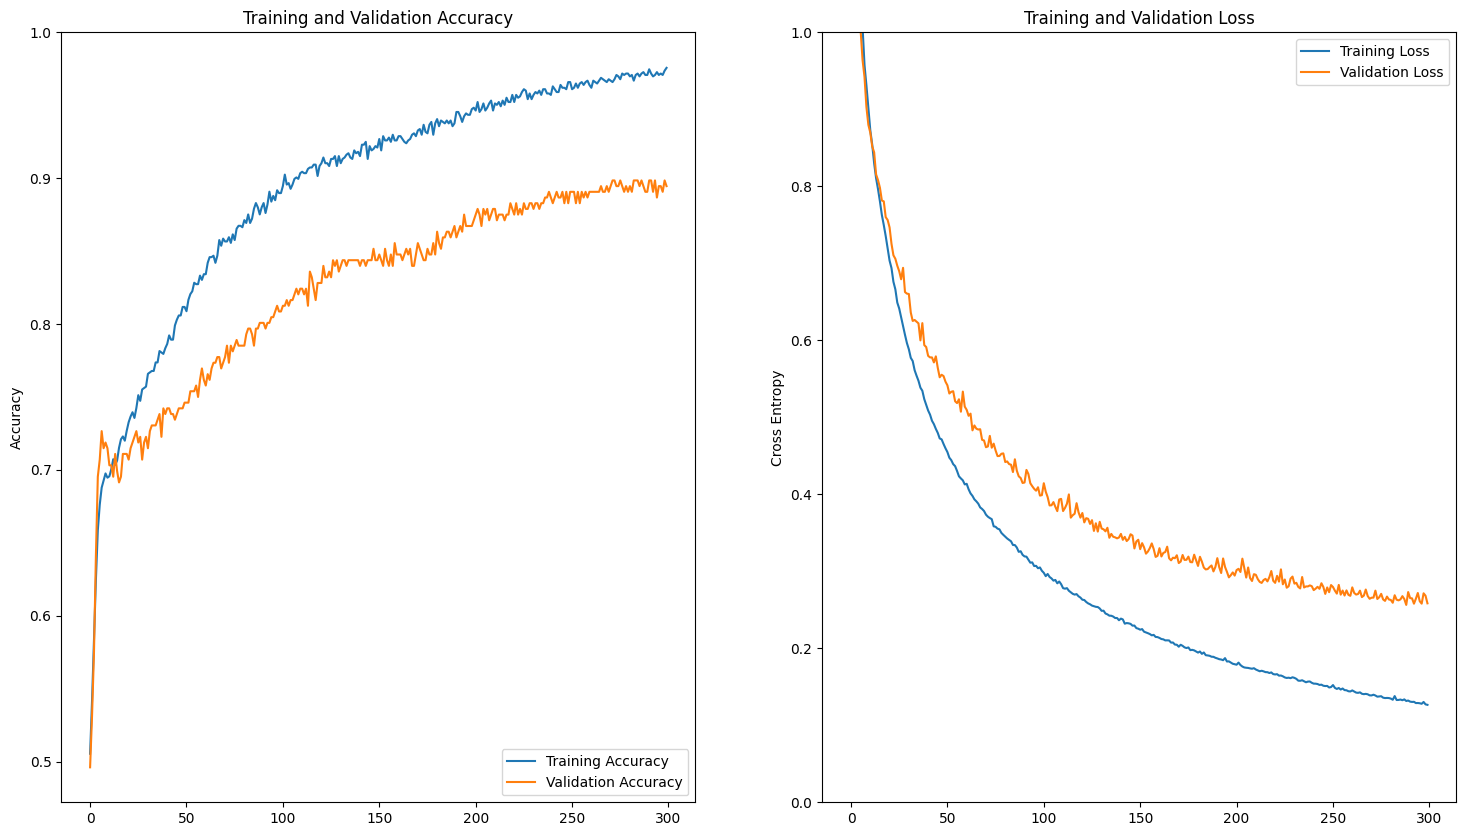

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(full_history.history['accuracy'], label='Training Accuracy')
plt.plot(full_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(full_history.history['loss'], label='Training Loss')
plt.plot(full_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.show()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(validation_dataset))

# Predict the labels for the images
predictions = model.predict(images)

# Plot the images and their predicted labels
plt.figure(figsize=(18, 18))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(f"Predicted: {predictions[i][0]:.2f} ({'lion' if predictions[i][0] < 0.5 else 'no lion'}), Actual: {labels[i]} ({'lion' if labels[i] == 0 else 'no lion'})")
  plt.axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# classification_directory = '/content/drive/MyDrive/lion_no_lion/stable/angle 1'
classification_directory = '/content/drive/MyDrive/lion_no_lion/stable/angle 2/Lion'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/cougar'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/lion'
# classification_directory = '/content/drive/MyDrive/lion_no_lion/nocougar'
classification_image_files = glob.glob(os.path.join(classification_directory,"*JPG"))
classifications = []
for image_file in classification_image_files:
    image_data = tf.keras.utils.load_img(image_file, target_size=image_dimensions)
    image_data = tf.keras.utils.img_to_array(image_data)
    prediction = model.predict(np.expand_dims(image_data, 0))
    classifications.append({})
    classifications[-1]['path'] = image_file
    classifications[-1]['image'] = image_data
    classifications[-1]['prediction'] = prediction[0][0]

    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(classifications[-1]['image'].astype("uint8")))
    plt.title(f'{(1-classifications[-1]["prediction"])*100:.2f}% lion - {classifications[-1]["prediction"]*100:.2f}% no_lion')
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.